# Shear Likelihood 2.1

### Preparing necessary libraries

In [2]:
import os
import sys
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
import time
from datetime import timedelta
from astropy import units
from numpy import random
plt.rcParams['text.latex.preamble'] = [r'\usepackage{pxfonts, mathpazo}']
plt.rcParams['font.family']=['Palatino']
plt.rc('text', usetex=True)


import clmm.dataops as da
import clmm.theory as theory
from clmm import Cosmology
from clmm.support import mock_data as mock
from clmm.utils import convert_units
from scipy.stats import chi2
from scipy.stats import kstest
import corner
import math

### Creating mock data

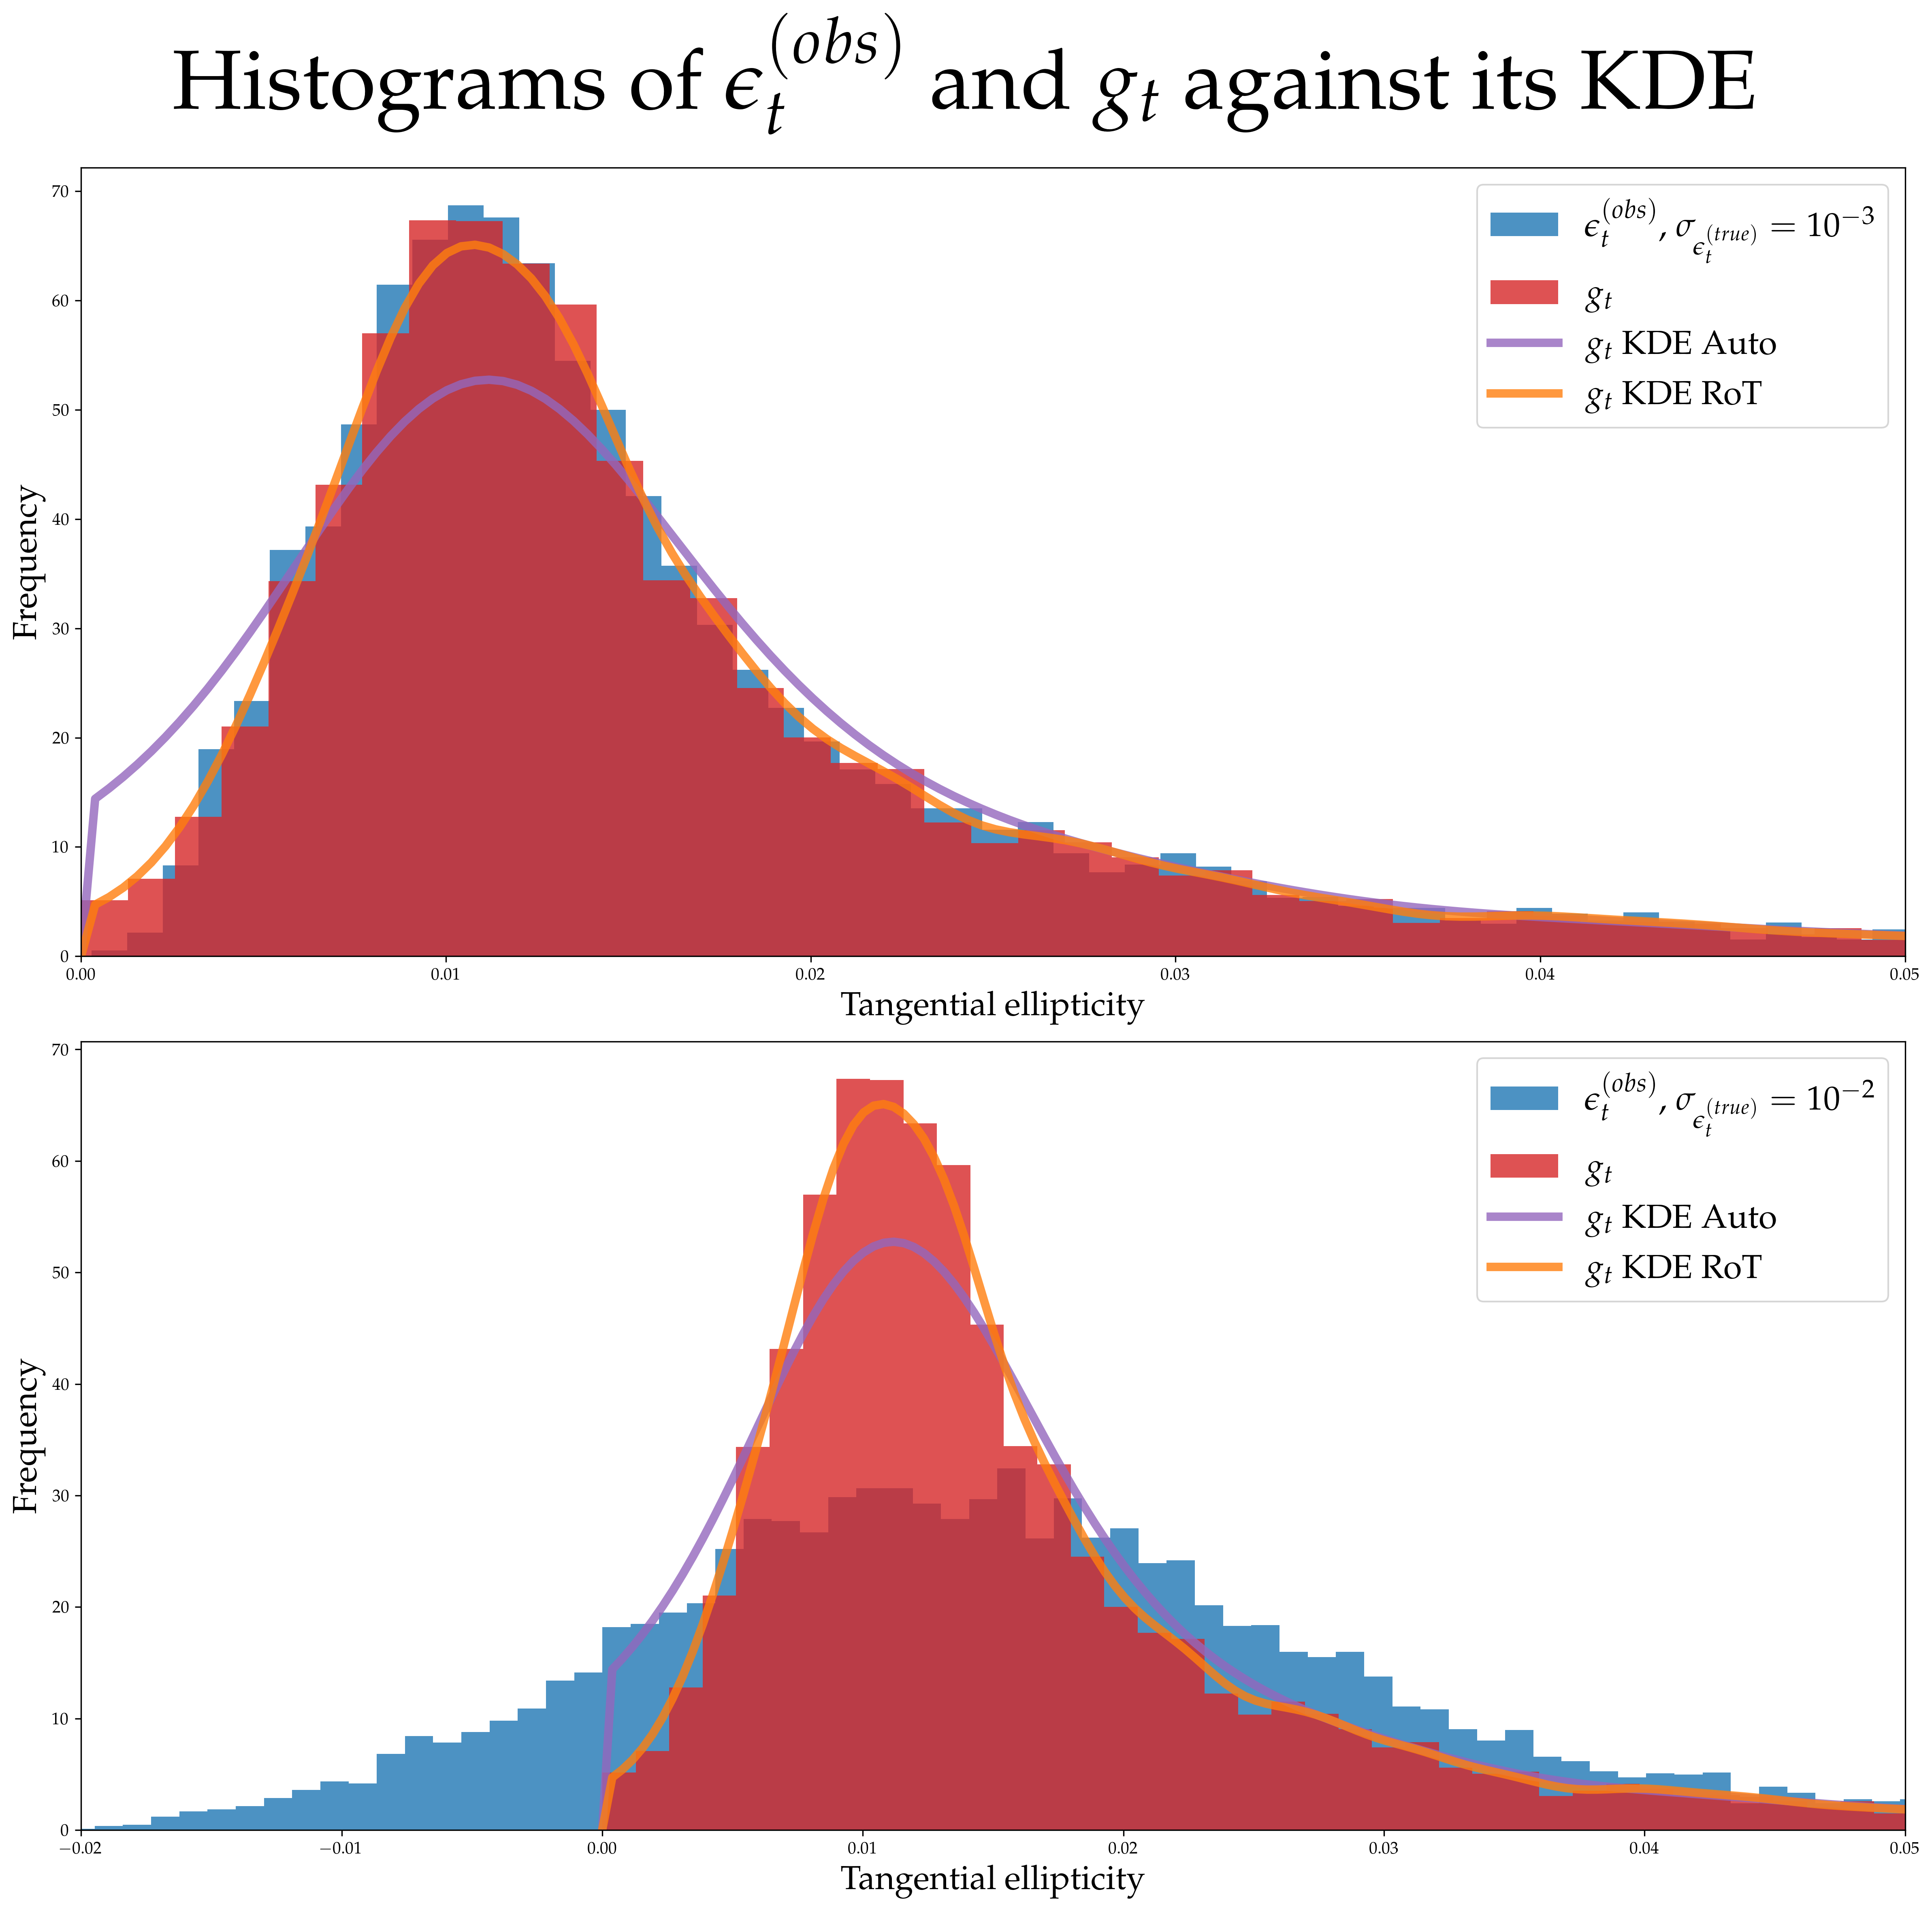

In [16]:
np.random.seed(0)

# Define cosmological parameters
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
    
cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
shapenoise    = 1.e-3 # True ellipticity standard variation

# Create galaxy catalog and Cluster object
data_small = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
gc_small = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data_small)
gc_small.compute_tangential_and_cross_components(geometry="flat")
radius_small = convert_units(gc_small.galcat['theta'], 'radians', 'Mpc', redshift=gc_small.z, cosmo=cosmo)
shear_small = clmm.compute_reduced_tangential_shear(radius_small, cluster_m, concentration, gc_small.z, gc_small.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')

np.random.seed(0)

shapenoise = 1.e-2

data_large = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
gc_large = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data_large)
gc_large.compute_tangential_and_cross_components(geometry="flat")
radius_large = convert_units(gc_large.galcat['theta'], 'radians', 'Mpc', redshift=gc_large.z, cosmo=cosmo)
shear_large = clmm.compute_reduced_tangential_shear(radius_large, cluster_m, concentration, gc_large.z, gc_large.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')


shear_kde_small     = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
shear_kde_small_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

for gt in shear_small:
    if gt != 0:
        shear_kde_small.add_obs(gt)
        shear_kde_small_rot.add_obs(gt)

shear_kde_small.prepare()
shear_kde_small_rot.prepare()


shear_kde_large     = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
shear_kde_large_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

for gt in shear_large:
    if gt != 0:
        shear_kde_large.add_obs(gt)
        shear_kde_large_rot.add_obs(gt)

shear_kde_large.prepare()
shear_kde_large_rot.prepare()



fig, ax = plt.subplots(2, 1, figsize=(16,16), dpi=300, facecolor="white")

fig.suptitle(f'Histograms of $\\epsilon_t^{{(obs)}}$ and $g_t$ against its KDE', fontsize='50', weight='bold')

x_small = np.linspace(min(shear_small), max(shear_small), 1000)
y_small = [shear_kde_small.eval_p(xi) for xi in x_small]
z_small = [shear_kde_small_rot.eval_p(xi) for xi in x_small]

ax[0].hist(gc_small.galcat['et'], bins=300, color='tab:blue', alpha=0.8, density=True, label=f"$\\epsilon_t^{{(obs)}}$, $\\sigma_{{\\epsilon_t^{{(true)}}}}=10^{{-3}}$")
ax[0].hist(shear_small, bins=300, color='tab:red', alpha=0.8, density=True, label=f"$g_t$")
ax[0].plot(x_small, y_small, color='tab:purple', label=f"$g_t$ KDE Auto", linewidth=5, alpha=0.8)
ax[0].plot(x_small, z_small, color='tab:orange', label=f"$g_t$ KDE RoT", linewidth=5, alpha=0.8)
ax[0].set_xlim(0, 0.05)

ax[0].set_xlabel(f"Tangential ellipticity", fontsize=20)
ax[0].set_ylabel(f"Frequency", fontsize=20)

ax[0].legend(fontsize=20)

x_large = np.linspace(min(shear_large), max(shear_large), 1000)
y_large = [shear_kde_large.eval_p(xi) for xi in x_large]
z_large = [shear_kde_large_rot.eval_p(xi) for xi in x_large]

ax[1].hist(gc_large.galcat['et'], bins=300, color='tab:blue', alpha=0.8, density=True, label=f"$\\epsilon_t^{{(obs)}}$, $\\sigma_{{\\epsilon_t^{{(true)}}}}=10^{{-2}}$")
ax[1].hist(shear_large, bins=300, color='tab:red', alpha=0.8, density=True, label=f"$g_t$")
ax[1].plot(x_large, y_large, color='tab:purple', label=f"$g_t$ KDE Auto", linewidth=5, alpha=0.8)
ax[1].plot(x_large, z_large, color='tab:orange', label=f"$g_t$ KDE RoT", linewidth=5, alpha=0.8)
ax[1].set_xlim(-0.02, 0.05)


ax[1].set_xlabel(f"Tangential ellipticity", fontsize=20)
ax[1].set_ylabel(f"Frequency", fontsize=20)

ax[1].legend(fontsize=20)

fig.tight_layout()
fig.subplots_adjust(top=0.9)

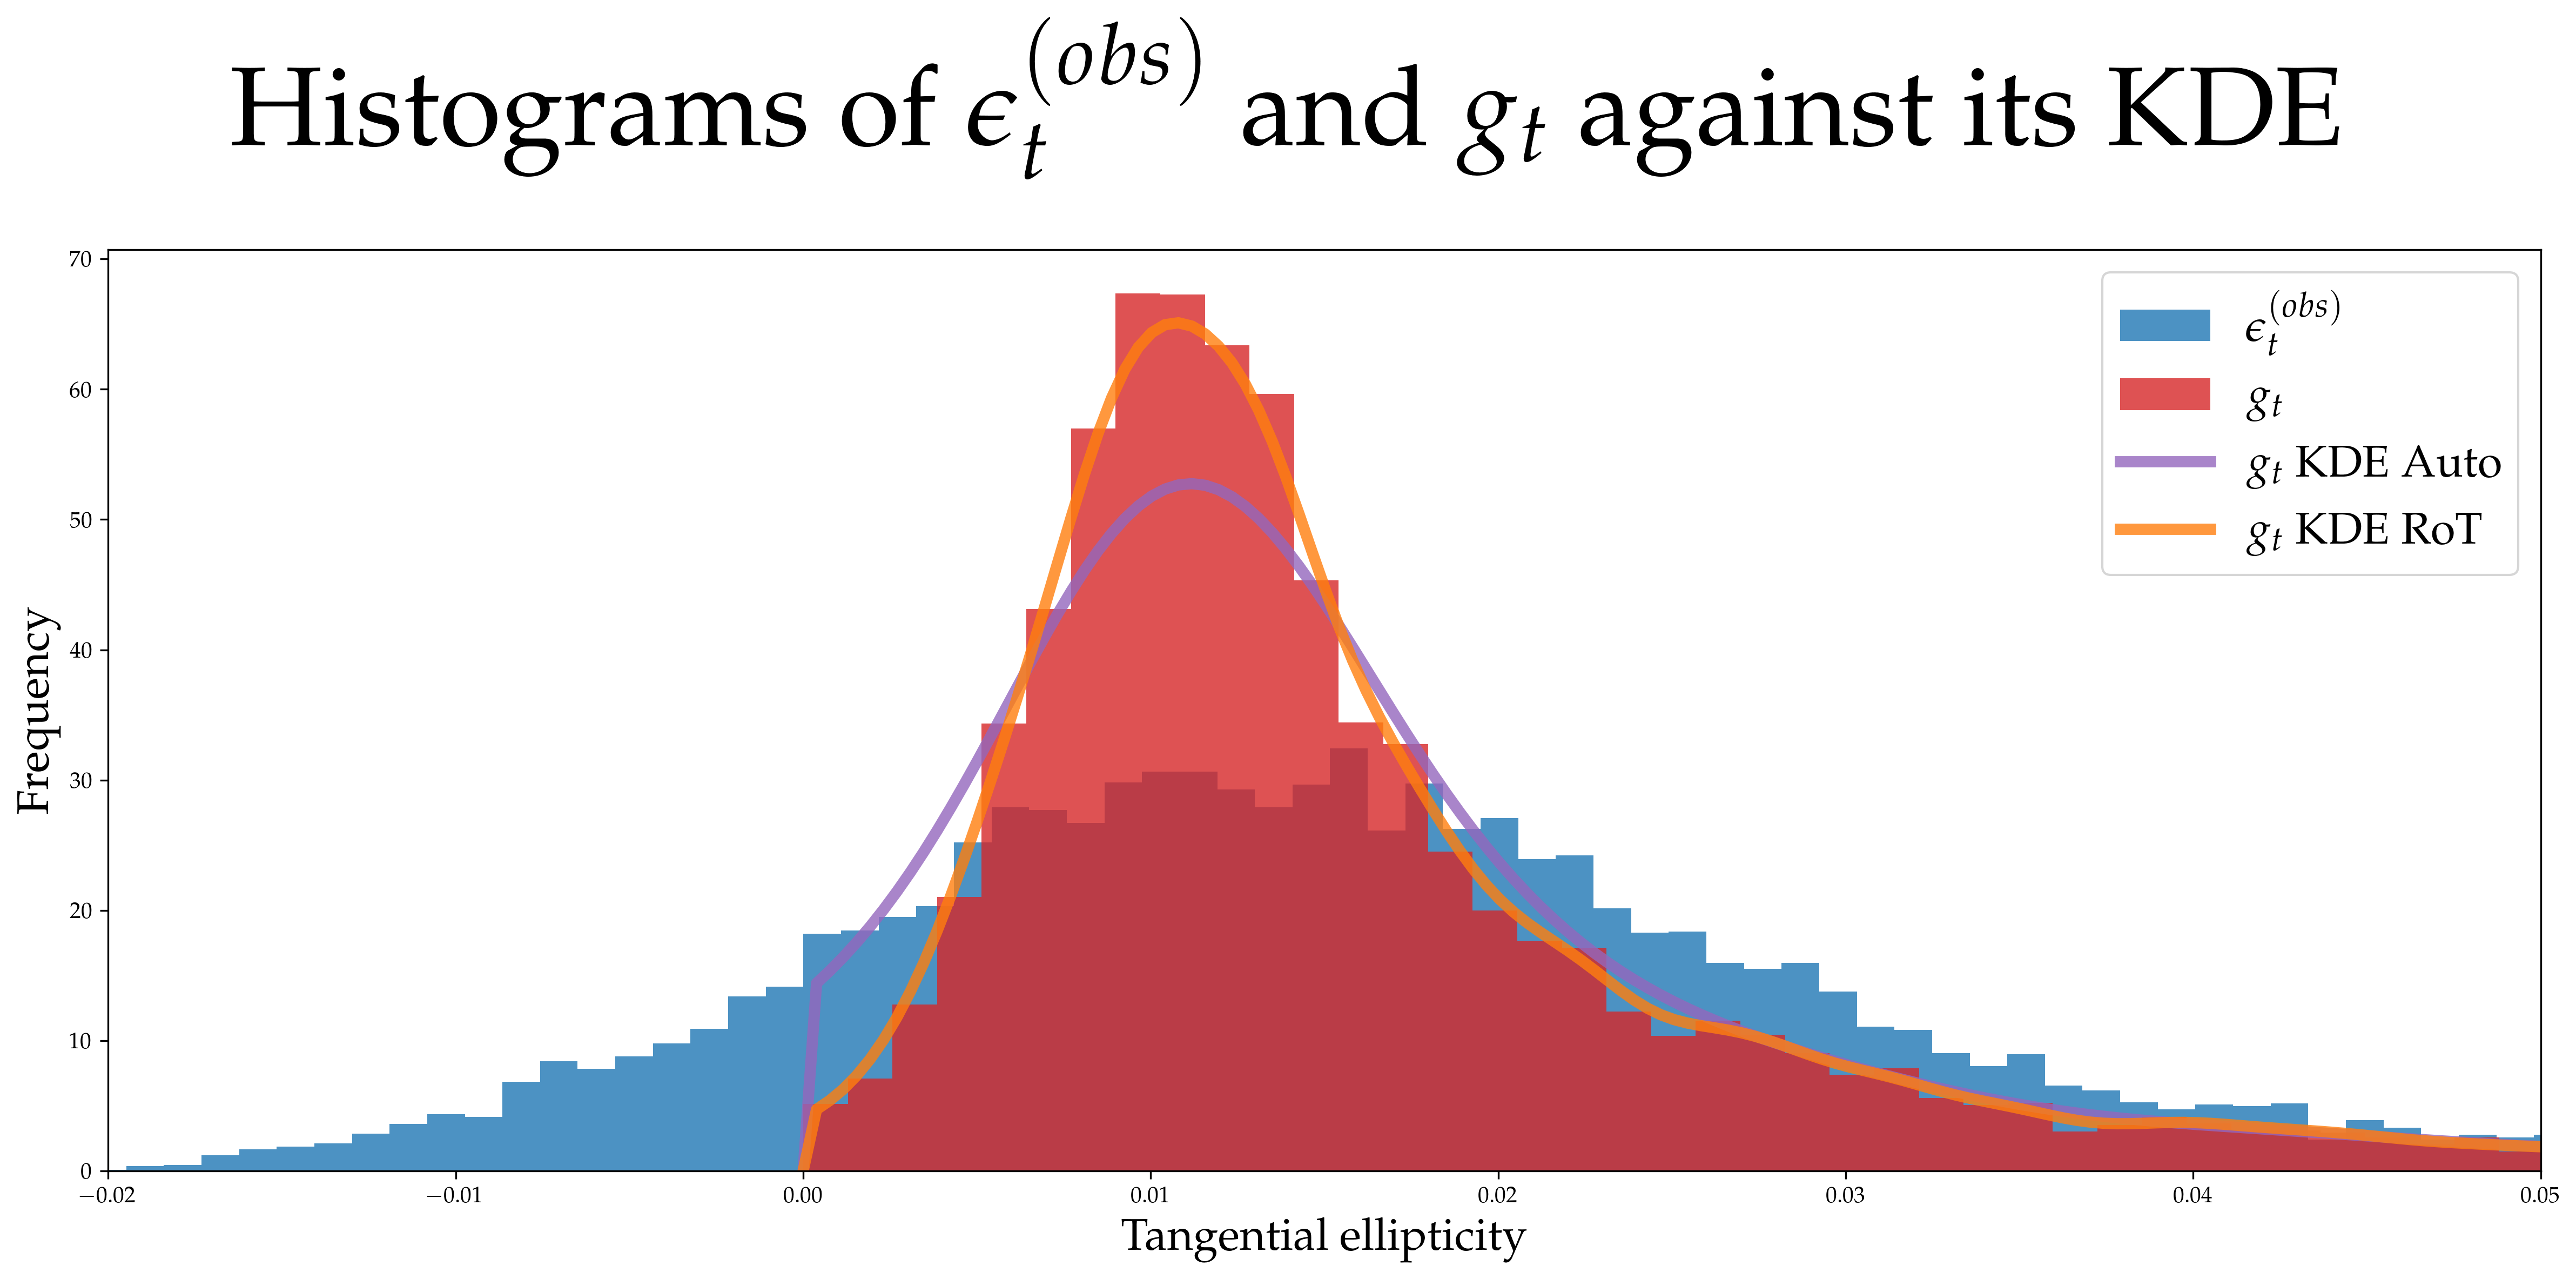

In [4]:
np.random.seed(0)

# Define cosmological parameters
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
    
cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
shapenoise    = 1.e-2 # True ellipticity standard variation

# Create galaxy catalog and Cluster object
data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)

gc.compute_tangential_and_cross_components(geometry="flat")
radius = convert_units(gc.galcat['theta'], 'radians', 'Mpc', redshift=gc.z, cosmo=cosmo)

# Create binning profile por binned methods
bin_edges = da.make_bins(0.7, 4, 50, method="evenlog10width")
profile = gc.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)

shear = clmm.compute_reduced_tangential_shear(radius, cluster_m, concentration, gc.z, gc.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')

shear_kde     = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)
shear_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

for gt in shear:
    if gt != 0:
        shear_kde.add_obs(gt)
        shear_kde_rot.add_obs(gt)

shear_kde.prepare()
shear_kde_rot.prepare()

fig, ax = plt.subplots(1, 1, figsize=(16,8), dpi=300, facecolor="white")

fig.suptitle(f'Histograms of $\\epsilon_t^{{(obs)}}$ and $g_t$ against its KDE', fontsize='50', weight='bold')

x = np.linspace(min(shear), max(shear), 1000)
y = [shear_kde.eval_p(xi) for xi in x]
z = [shear_kde_rot.eval_p(xi) for xi in x]

ax.hist(gc.galcat['et'], bins=300, color='tab:blue', alpha=0.8, density=True, label=f"$\\epsilon_t^{{(obs)}}$")
ax.hist(shear, bins=300, color='tab:red', alpha=0.8, density=True, label=f"$g_t$")
ax.plot(x, y, color='tab:purple', label=f"$g_t$ KDE Auto", linewidth=5, alpha=0.8)
ax.plot(x, z, color='tab:orange', label=f"$g_t$ KDE RoT", linewidth=5, alpha=0.8)
ax.set_xlim(-0.02, 0.05)

ax.set_xlabel(f"Tangential ellipticity", fontsize=20)
ax.set_ylabel(f"Frequency", fontsize=20)

ax.legend(fontsize=20)

fig.tight_layout()
fig.subplots_adjust(top=0.80)

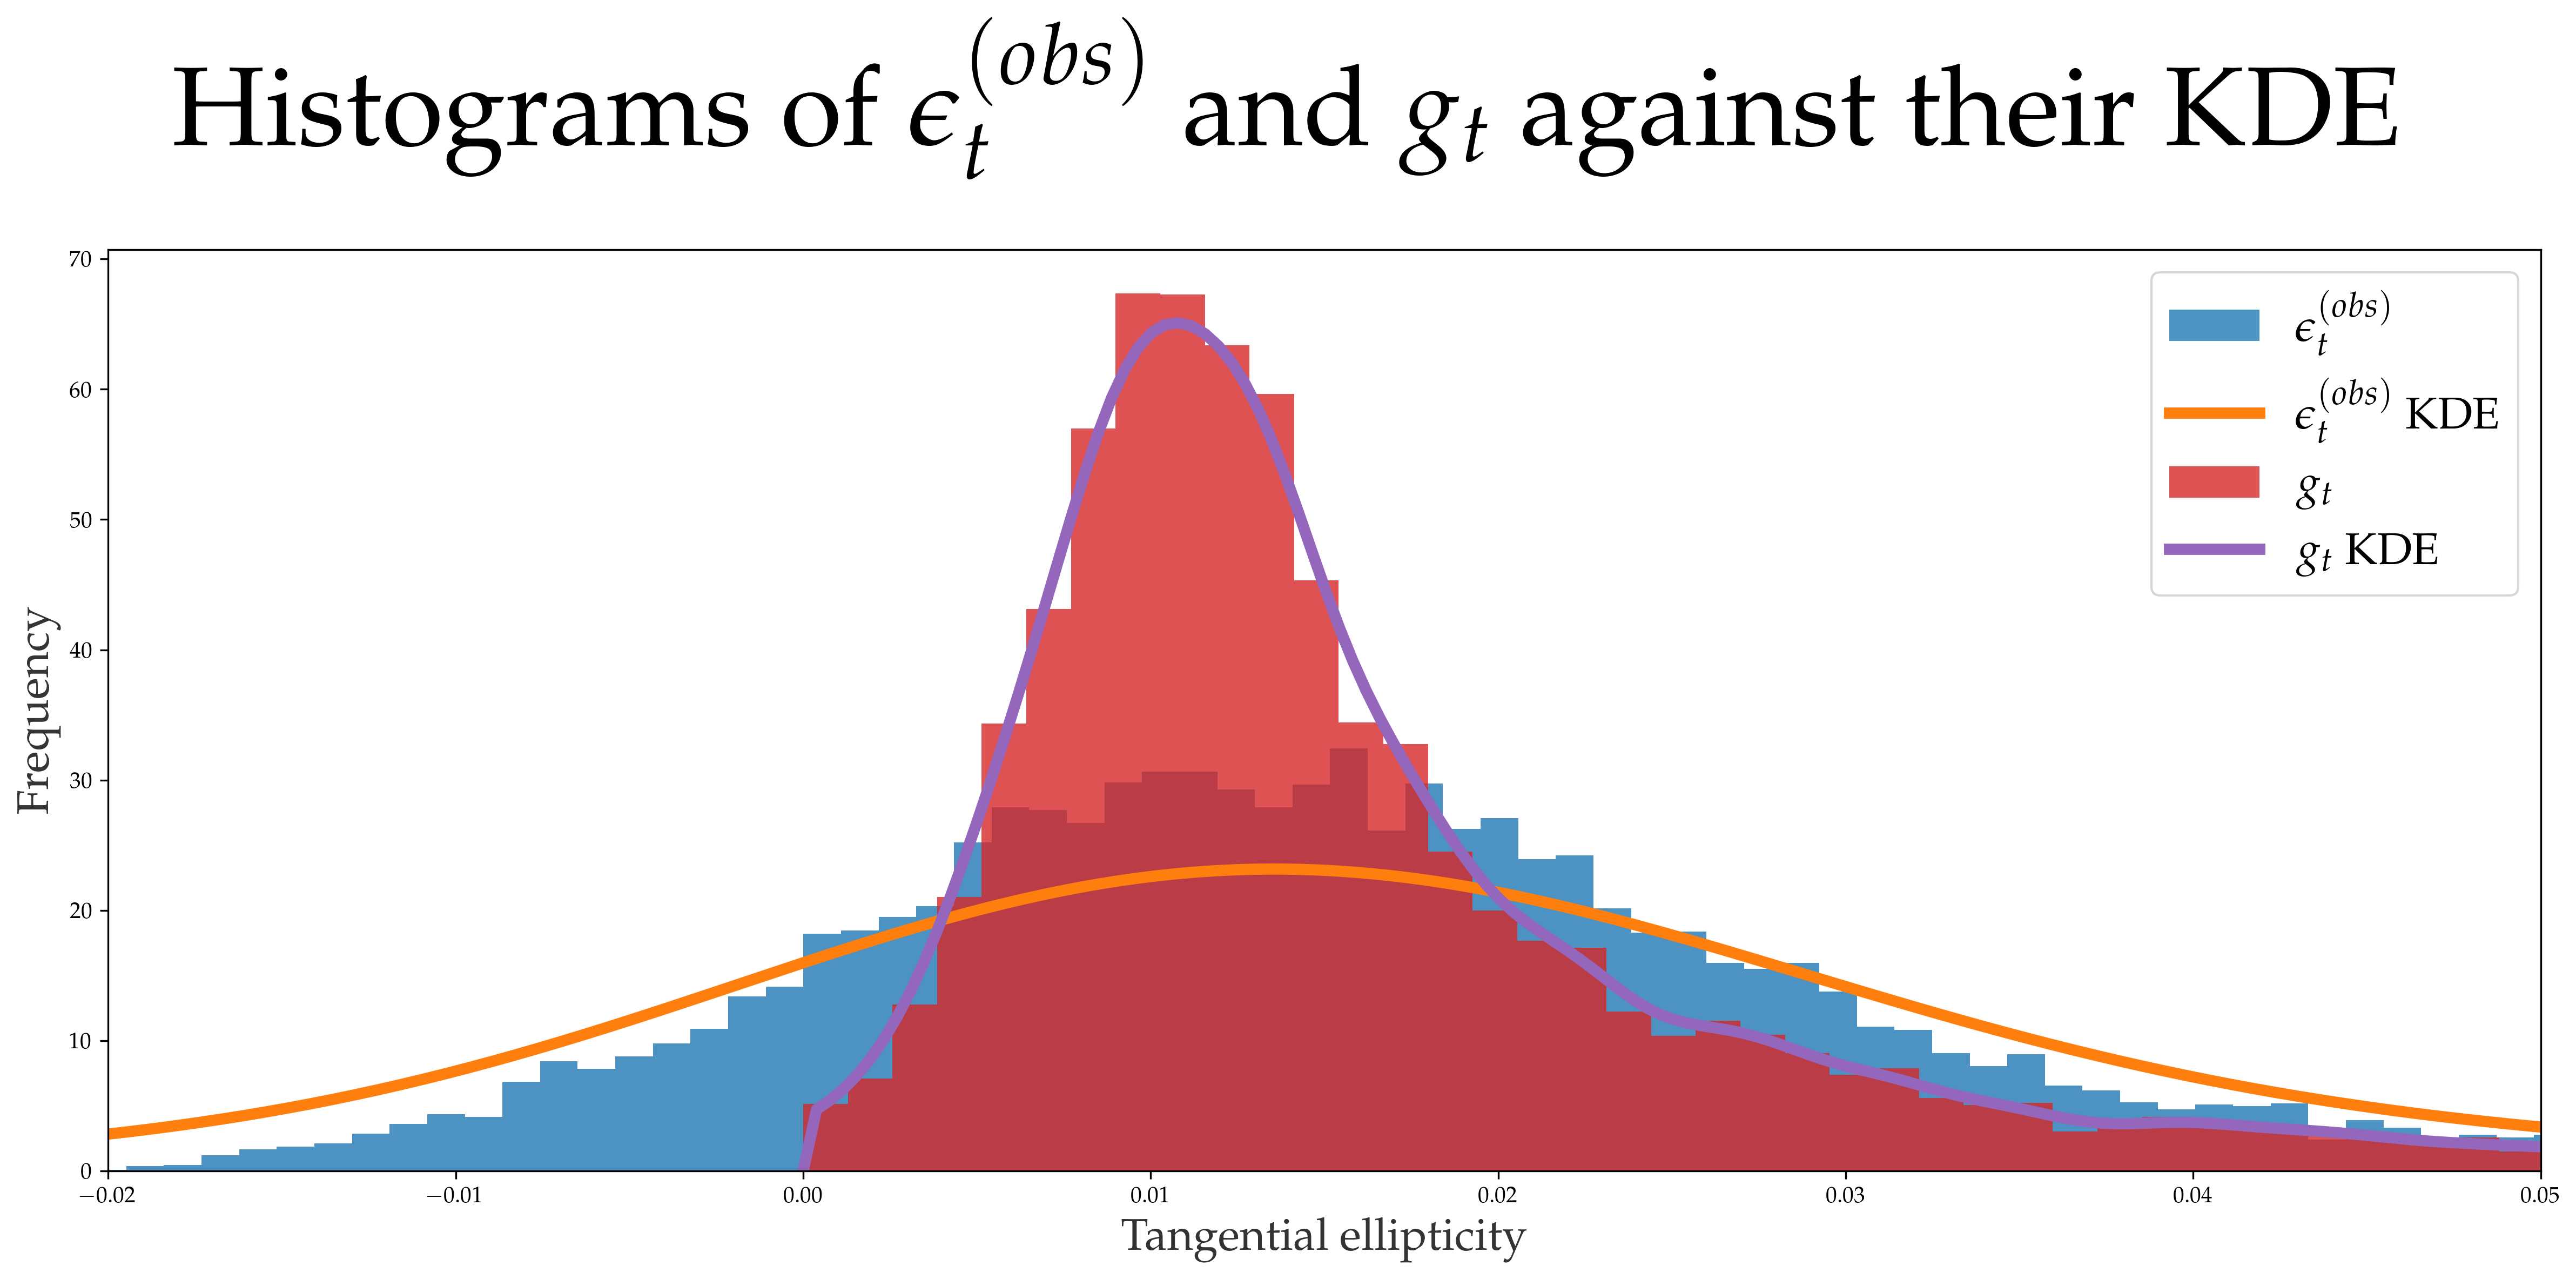

In [5]:
np.random.seed(0)

# Define cosmological parameters
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
    
cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
shapenoise    = 1.e-2 # True ellipticity standard variation

# Create galaxy catalog and Cluster object
data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)

gc.compute_tangential_and_cross_components(geometry="flat")
radius = convert_units(gc.galcat['theta'], 'radians', 'Mpc', redshift=gc.z, cosmo=cosmo)

# Create binning profile por binned methods
bin_edges = da.make_bins(0.7, 4, 50, method="evenlog10width")
profile = gc.make_radial_profile("Mpc", bins=bin_edges,cosmo=cosmo, gal_ids_in_bins=True)

shear = clmm.compute_reduced_tangential_shear(radius, cluster_m, concentration, gc.z, gc.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')

iqr = np.subtract(*np.percentile(shear, [75, 25]))
bw = 0.9 * min(np.std(shear), iqr/1.34) * ngals**(-1/5)

et_kde = Ncm.StatsDist1dEPDF.new_full(2000, Ncm.StatsDist1dEPDFBw.FIXED, 1, 0.001)
et_kde.props.h_fixed = np.sqrt(bw**2 + shapenoise**2)

shear_kde_rot = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

for gt in shear:
    if gt != 0:
        shear_kde_rot.add_obs(gt)

shear_kde_rot.prepare()

for et in gc.galcat['et']:
    if et != 0:
        et_kde.add_obs(et)

et_kde.prepare()

fig, ax = plt.subplots(1, 1, figsize=(16,8), dpi=300, facecolor="white")

fig.suptitle(f'Histograms of $\\epsilon_t^{{(obs)}}$ and $g_t$ against their KDE', fontsize='50', weight='bold')

x1 = np.linspace(min(shear), max(shear), 1000)
x2 = np.linspace(min(gc.galcat['et']), max(gc.galcat['et']), 1000)
y1 = [shear_kde_rot.eval_p(xi) for xi in x1]
y2 = [et_kde.eval_p(xi) for xi in x2]


ax.hist(gc.galcat['et'], bins=300, color='tab:blue', alpha=0.8, density=True, label=f"$\\epsilon_t^{{(obs)}}$")
ax.plot(x2, y2, color='tab:orange', label=f"$\\epsilon_t^{{(obs)}}$ KDE", linewidth=5)

ax.hist(shear, bins=300, color='tab:red', alpha=0.8, density=True, label=f"$g_t$")
ax.plot(x1, y1, color='tab:purple', label=f"$g_t$ KDE", linewidth=5)
ax.set_xlim(-0.02, 0.05)

ax.set_xlabel(f"Tangential ellipticity", fontsize=20, alpha=0.8)
ax.set_ylabel(f"Frequency", fontsize=20, alpha=0.8)

ax.legend(fontsize=20)

fig.tight_layout()
fig.subplots_adjust(top=0.80)

In [ ]:
shapenoise = [1e-4, 1e-3, 1e-2, 1e-1, 1]
n_runs     = 100

np.seterr(all="ignore")

percent_done = 0
t0 = time.time()


p_value_gt = []
p_value_gt_auto = []
# p_value_et = []

for i in range(len(shapenoise)):

    p_value_gt_sn = []
    p_value_gt_auto_sn = []
    # p_value_et_sn = []

    for j in range(n_runs):

        data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=shapenoise[i], photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
        gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)
        gc.compute_tangential_and_cross_components(geometry="flat")
        radius = convert_units(gc.galcat['theta'], 'radians', 'Mpc', redshift=gc.z, cosmo=cosmo)
        shear = clmm.compute_reduced_tangential_shear(radius, cluster_m, concentration, gc.z, gc.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')

        # iqr = np.subtract(*np.percentile(shear, [75, 25]))
        # bw = 0.9 * min(np.std(shear), iqr/1.34) * ngals**(-1/5)

        # et_kde = Ncm.StatsDist1dEPDF.new_full(2000, Ncm.StatsDist1dEPDFBw.FIXED, 1, 0.001)
        # et_kde.props.h_fixed = np.sqrt(bw**2 + shapenoise[i]**2)
        gt_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
        gt_kde_auto = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)

        for gt in shear:
            if gt != 0:
                gt_kde.add_obs(gt)
                gt_kde_auto.add_obs(gt)

        # for et in gc.galcat['et']:
        #     if et != 0:
        #         et_kde.add_obs(et)

        gt_kde.prepare()
        gt_kde_auto.prepare()
        # et_kde.prepare()

        p_value_gt_sn.append(kstest(shear, lambda gt_array : [gt_kde.eval_pdf(gt) for gt in gt_array])[1])
        p_value_gt_auto_sn.append(kstest(shear, lambda gt_array : [gt_kde_auto.eval_pdf(gt) for gt in gt_array])[1])
        # p_value_et_sn.append(kstest(gc.galcat['et'], lambda et_array : [et_kde.eval_pdf(et) for et in et_array])[1])
            
        percent_done += 1/5/100
        elapsed_time  = time.time() - t0
        time_left     = elapsed_time/percent_done - elapsed_time
        print(f'Percent done: {percent_done*100:.4f}%. Elapsed time: {str(timedelta(seconds=elapsed_time))}. Time left: {str(timedelta(seconds=time_left))}')
    
    p_value_gt.append(np.mean(p_value_gt_sn))
    p_value_gt_auto.append(np.mean(p_value_gt_auto_sn))
    # p_value_et.append(np.mean(p_value_et_sn))

In [17]:
shapenoise = 1.e-3
n_runs     = 1000

np.seterr(all="ignore")

percent_done = 0
t0 = time.time()


p_value_gt = []
p_value_gt_auto = []

for j in range(n_runs):

    data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
    gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)
    gc.compute_tangential_and_cross_components(geometry="flat")
    radius = convert_units(gc.galcat['theta'], 'radians', 'Mpc', redshift=gc.z, cosmo=cosmo)
    shear = clmm.compute_reduced_tangential_shear(radius, cluster_m, concentration, gc.z, gc.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')
    shear_cut = [gt for gt in shear if gt > 0 and gt < 0.05]
    # iqr = np.subtract(*np.percentile(shear, [75, 25]))
    # bw = 0.9 * min(np.std(shear), iqr/1.34) * ngals**(-1/5)

    # et_kde = Ncm.StatsDist1dEPDF.new_full(2000, Ncm.StatsDist1dEPDFBw.FIXED, 1, 0.001)
    # et_kde.props.h_fixed = np.sqrt(bw**2 + shapenoise[i]**2)
    gt_kde = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)
    # gt_kde_auto = Ncm.StatsDist1dEPDF.new_full (2000, Ncm.StatsDist1dEPDFBw.AUTO, 1, 0.001)

    for gt in shear_cut:
        # if gt != 0:
        gt_kde.add_obs(gt)
            # gt_kde_auto.add_obs(gt)

    # for et in gc.galcat['et']:
    #     if et != 0:
    #         et_kde.add_obs(et)

    gt_kde.prepare()
    # gt_kde_auto.prepare()
    # et_kde.prepare()

    p_value_gt.append(kstest(shear_cut, lambda gt_array : [gt_kde.eval_pdf(gt) for gt in gt_array])[1])
    # p_value_gt_auto_sn.append(kstest(shear, lambda gt_array : [gt_kde_auto.eval_pdf(gt) for gt in gt_array])[1])
    # p_value_et_sn.append(kstest(gc.galcat['et'], lambda et_array : [et_kde.eval_pdf(et) for et in et_array])[1])
        
    percent_done += 1/n_runs
    elapsed_time  = time.time() - t0
    time_left     = elapsed_time/percent_done - elapsed_time
    print(f'Percent done: {percent_done*100:.4f}%. Elapsed time: {str(timedelta(seconds=elapsed_time))}. Time left: {str(timedelta(seconds=time_left))}')

Percent done: 0.1000%. Elapsed time: 0:00:00.466241. Time left: 0:07:45.775118
Percent done: 0.2000%. Elapsed time: 0:00:00.922781. Time left: 0:07:40.467952
Percent done: 0.3000%. Elapsed time: 0:00:01.387506. Time left: 0:07:41.114576
Percent done: 0.4000%. Elapsed time: 0:00:01.864950. Time left: 0:07:44.372535
Percent done: 0.5000%. Elapsed time: 0:00:02.341034. Time left: 0:07:45.865801
Percent done: 0.6000%. Elapsed time: 0:00:02.811799. Time left: 0:07:45.821297
Percent done: 0.7000%. Elapsed time: 0:00:03.291959. Time left: 0:07:46.987905
Percent done: 0.8000%. Elapsed time: 0:00:03.752911. Time left: 0:07:45.360975
Percent done: 0.9000%. Elapsed time: 0:00:04.216481. Time left: 0:07:44.281378
Percent done: 1.0000%. Elapsed time: 0:00:04.682722. Time left: 0:07:43.589440
Percent done: 1.1000%. Elapsed time: 0:00:05.139725. Time left: 0:07:42.107978
Percent done: 1.2000%. Elapsed time: 0:00:05.593288. Time left: 0:07:40.514041
Percent done: 1.3000%. Elapsed time: 0:00:06.069607.

0.25742282811396877
0.2555121983592328
0.0


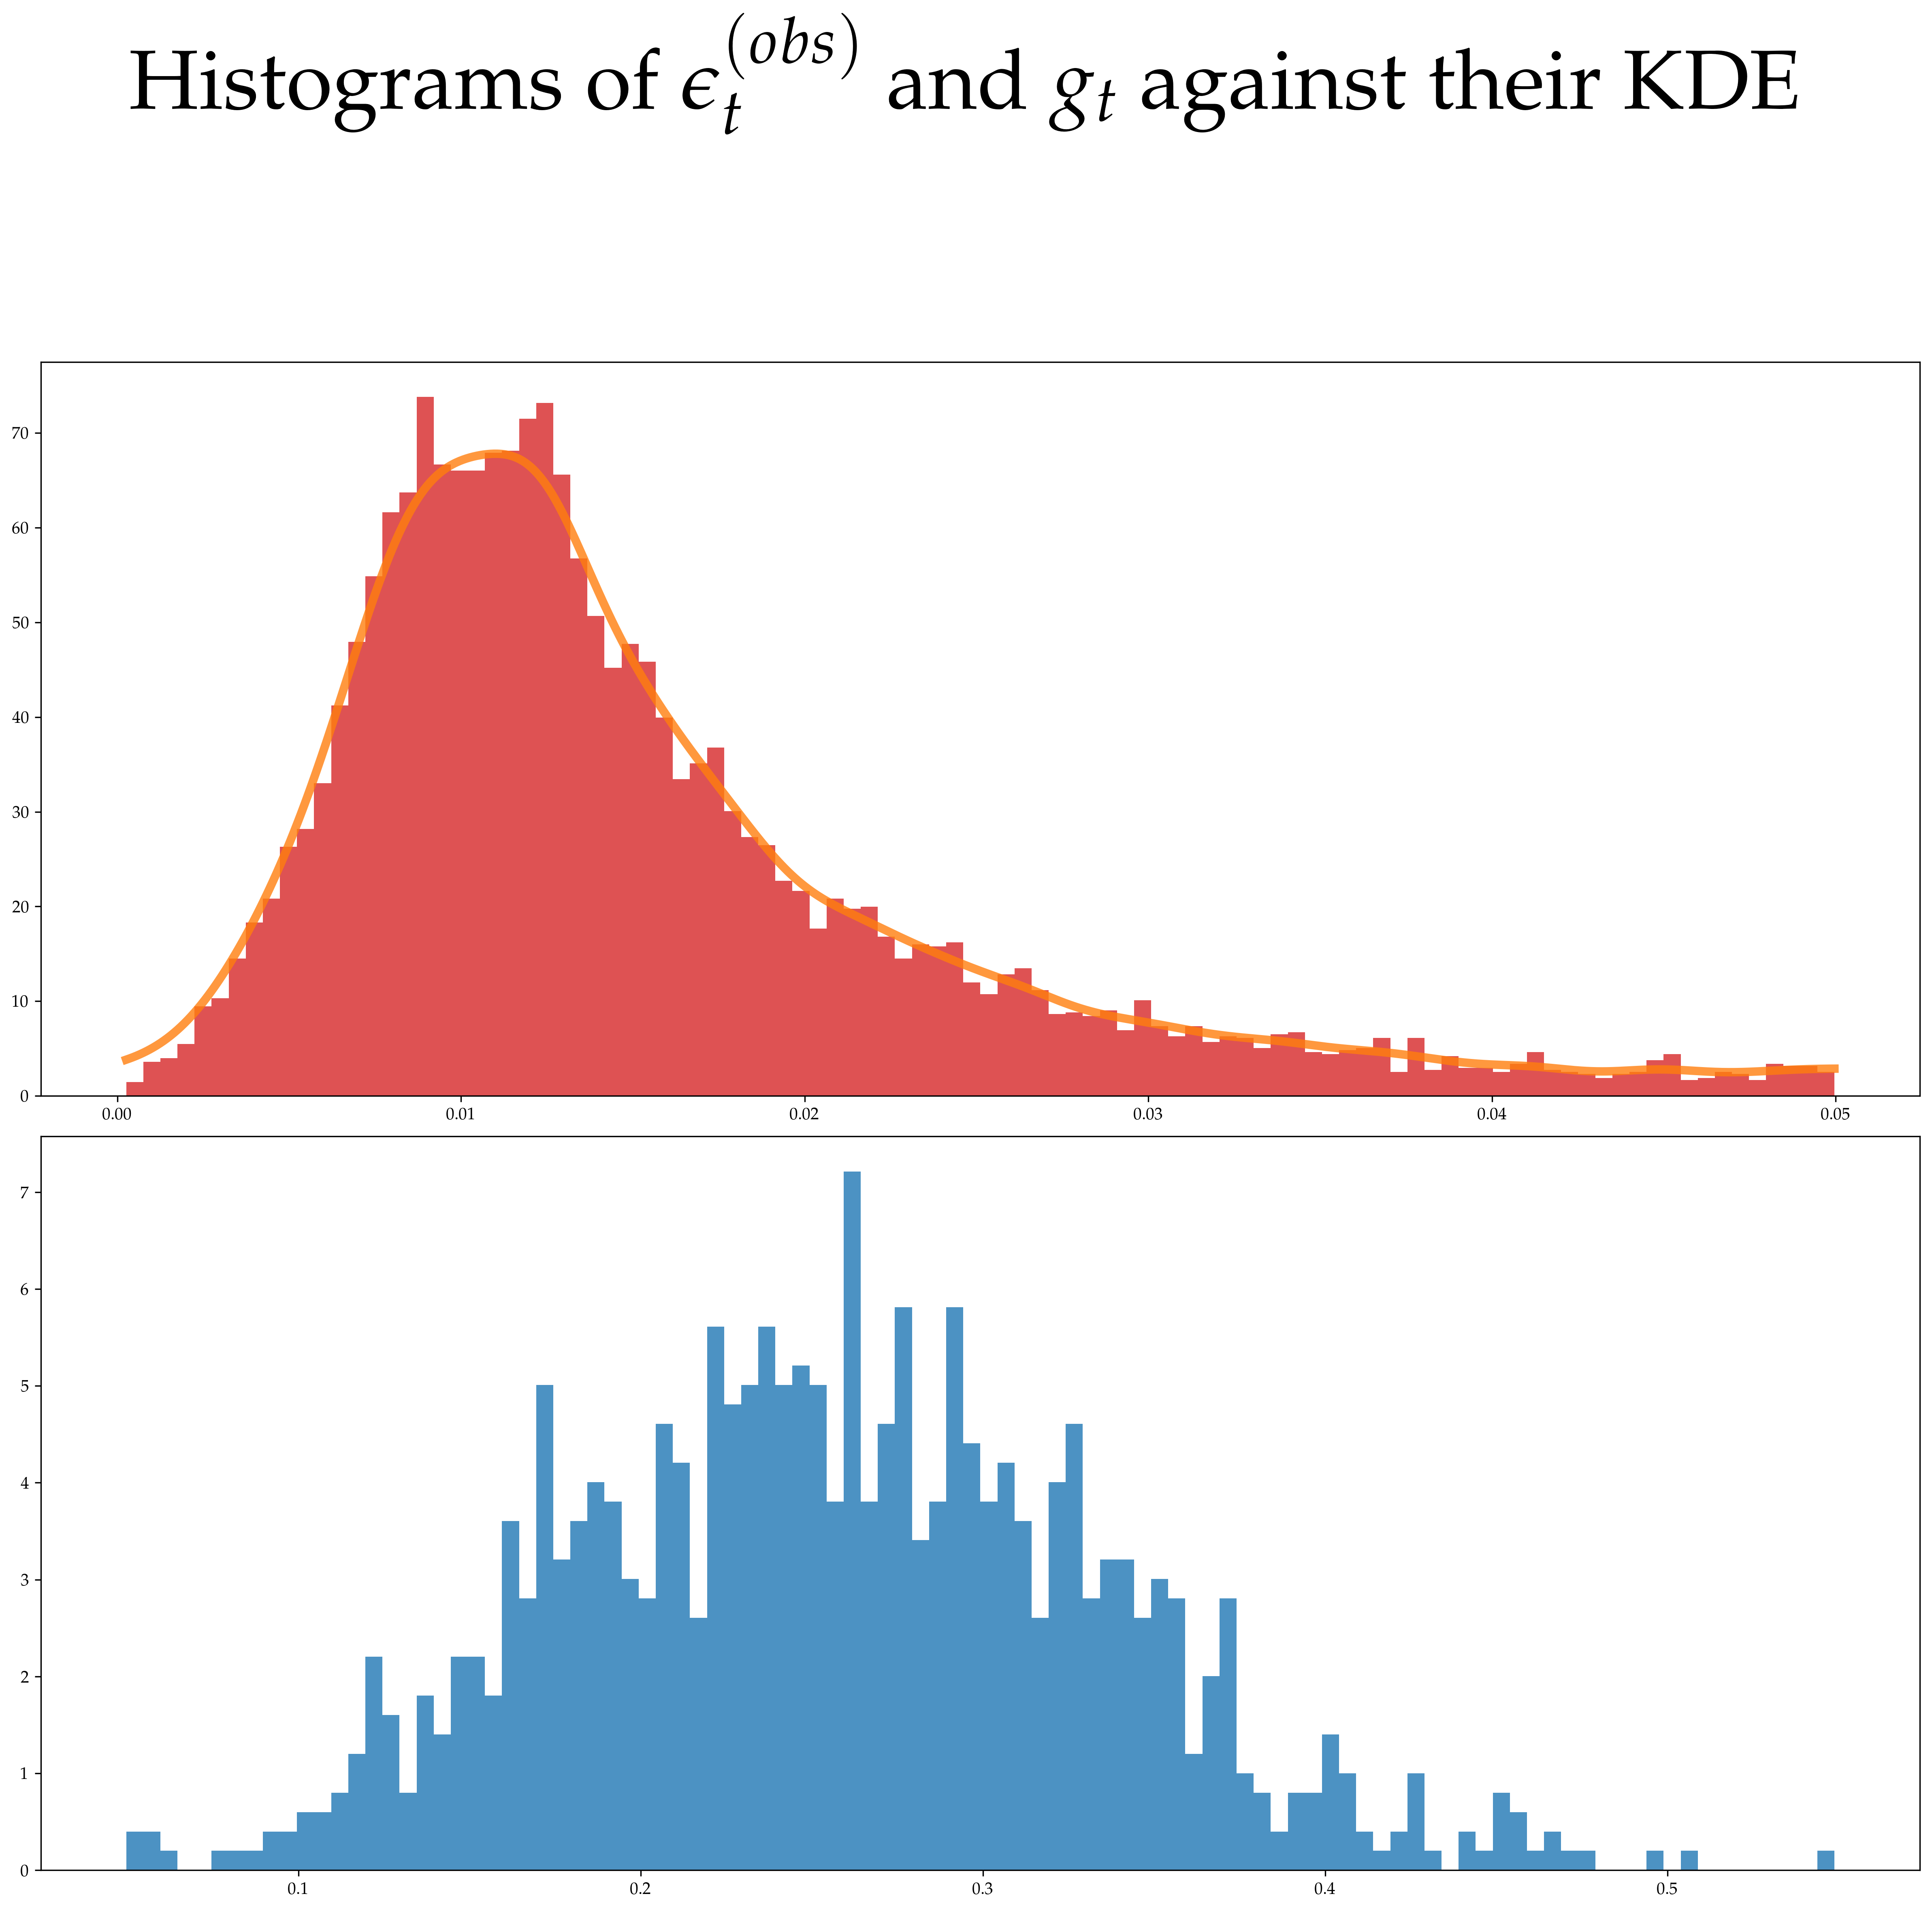

In [23]:
np.random.seed(0)

# Define cosmological parameters
cosmo = Cosmology(H0 = 70.0, Omega_dm0 = 0.27 - 0.045, Omega_b0 = 0.045, Omega_k0 = 0.0)
    
cluster_m     = 1.e15 # Cluster mass
cluster_z     = 0.4   # Cluster redshift
concentration = 4     # Concentrion parameter NFW profile
ngals         = 10000 # Number of galaxies
Delta         = 200   # Overdensity parameter definition NFW profile
cluster_ra    = 0.0   # Cluster right ascension
cluster_dec   = 0.0   # Cluster declination
shapenoise    = 1.e-3 # True ellipticity standard variation

# Create galaxy catalog and Cluster object
data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, "chang13", zsrc_min = cluster_z + 0.1, shapenoise=shapenoise, photoz_sigma_unscaled=0.05, ngals=ngals, cluster_ra=cluster_ra, cluster_dec=cluster_dec)
gc = clmm.GalaxyCluster("CL_noisy_z", cluster_ra, cluster_dec, cluster_z, data)

gc.compute_tangential_and_cross_components(geometry="flat")
radius = convert_units(gc.galcat['theta'], 'radians', 'Mpc', redshift=gc.z, cosmo=cosmo)



fig, ax = plt.subplots(2, 1, figsize=(16,16), dpi=300, facecolor="white")

fig.suptitle(f'Histograms of $\\epsilon_t^{{(obs)}}$ and $g_t$ against their KDE', fontsize='50', weight='bold')

x = np.linspace(min(shear_cut), max(shear_cut), 1000)
y = [gt_kde.eval_p(xi) for xi in x]

ax[0].hist(shear_cut, bins=100, density=True, color='tab:red', alpha=0.8, label=f'$g_t$')
ax[0].plot(x, y, color='tab:purple', alpha=0.8, linewidth=5, label=f'$g_t$ KDE')
ax[0].set_xlabel(f'')

ax[1].hist(p_value_gt, bins=100, density=True, color='tab:blue', alpha=0.8)

fig.tight_layout()
fig.subplots_adjust(top=0.80)
print(np.mean(p_value_gt))
print(np.median(p_value_gt))
print(kstest(shear, lambda gt_array : [gt_kde.eval_pdf(gt) for gt in gt_array])[1])

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16,8), dpi=300, facecolor="white")

fig.suptitle(f'Histograms of $\\epsilon_t^{{(obs)}}$ and $g_t$ against their KDE', fontsize='50', weight='bold')

ax.plot(shapenoise, p_value_gt, marker='o', linestyle='-', label='$g_t$ KDE RoT', linewidth=5, alpha=0.8, markersize=10, color='tab:blue')
# ax.plot(shapenoise, p_value_gt_auto, marker='o', linestyle='-', label='$g_t$ KDE Auto', linewidth=5, alpha=0.8, markersize=10, color='tab:green')

# ax.set_title(f'$\\epsilon_t^{{(obs)}}$, Bin ${bins[i]+1}$, $\\bar{{N}}_{{gals}}={avg_n_gals_bin[0][i]:.0f}$', fontsize=20)
ax.set_xlabel(f'$\\epsilon_t^{{(true)}}$ standard deviation', fontsize=20)
ax.set_ylabel(f'P Value', fontsize=20)

ax.set_xscale('log')
ax.set_yscale('log')

ax.legend(fontsize=12)

fig.tight_layout()
fig.subplots_adjust(top=0.80)

### Updating the KDE for likelihood

In [ ]:
# for gt_th, gt_obs in zip(gt_th_noisy_z, gt_noisy_z):
#     if gt_th != 0:
#         gt_th_noisy_z_kde.add_obs(gt-gt_obs)
#         gt_th_noisy_z_kde_rot.add_obs(gt-gt_obs)

# gt_th_noisy_z_kde.prepare()
# gt_th_noisy_z_kde_rot.prepare()

In [ ]:
# import scipy.integrate as integrate

# result = integrate.quad(gt_th_noisy_z_kde.eval_p, -np.inf, np.inf)

In [ ]:
def shear_log_likelihood(logm, gc, radius, shapenoise, cosmo, sigma=1, concentration=4, delta=200, model='nfw'):

    m = float(10.**logm)
    gt_th = clmm.compute_reduced_tangential_shear(radius, m, concentration, gc.z, gc.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')
    gt_obs = gc.galcat['et']
    
    gt_th_kde_rot = Ncm.StatsDist1dEPDF.new_full(2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

    for gt in gt_th:
        if gt != 0:
            gt_th_kde_rot.add_obs(gt)
            

    gt_th_kde_rot.prepare()

    log_likelihood = 0

    for gt in gt_obs:
        log_likelihood += np.log(gt_th_kde_rot.eval_p(gt))
    
    return -2*log_likelihood


In [ ]:
from clmm.support.sampler import samplers

logm_0 = random.uniform(13., 17., 1)[0]

logm_est = samplers['basinhopping'](shear_log_likelihood, logm_0, minimizer_kwargs={'args':(gc_noisy_z, radius, shapenoise, cosmo)})

print(10.**logm_est)

In [ ]:
def shear_log_likelihood_2(logm, gc, radius, shapenoise, cosmo, sigma=1, concentration=4, delta=200, model='nfw'):

    m = float(10.**logm)
    gt_th = clmm.compute_reduced_tangential_shear(radius, m, concentration, gc.z, gc.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')
    gt_obs = gc.galcat['et']
    
    gt_th_kde_rot = Ncm.StatsDist1dEPDF.new_full(2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

    for gt in gt_th:
        if gt != 0:
            gt_th_kde_rot.add_obs(gt)
            

    gt_th_kde_rot.prepare()

    log_likelihood = 0

    for gt in gt_obs:
        if gt != 0:
            gt_th_kde_rot.add_obs(gt)
        log_likelihood += np.log(gt_th_kde_rot.eval_p(gt))
    
    return -2*log_likelihood


logm_est = samplers['basinhopping'](shear_log_likelihood_2, logm_0, minimizer_kwargs={'args':(gc_noisy_z, radius, shapenoise, cosmo)})

print(10.**logm_est)

In [ ]:
def shear_log_likelihood_3(logm, gc, radius, shapenoise, cosmo, sigma=1, concentration=4, delta=200, model='nfw'):

    m = float(10.**logm)
    gt_th = clmm.compute_reduced_tangential_shear(radius, m, concentration, gc.z, gc.galcat['z'], cosmo, delta_mdef=200, halo_profile_model='nfw')
    gt_obs = gc.galcat['et']
    
    gt_th_kde_rot = Ncm.StatsDist1dEPDF.new_full(2000, Ncm.StatsDist1dEPDFBw.ROT, 1, 0.001)

    for gt in gt_th:
        if gt != 0:
            gt_th_kde_rot.add_obs(gt)
            

    gt_th_kde_rot.prepare()

    log_likelihood = 0

    for gt in gt_obs:
        for gt_l in gt_th:
            if gt-gt_l > 0:
                gt_th_kde_rot.add_obs(gt-gt_l)
        log_likelihood += np.log(gt_th_kde_rot.eval_p(gt))
    
    return -2*log_likelihood


logm_est = samplers['basinhopping'](shear_log_likelihood_3, logm_0, minimizer_kwargs={'args':(gc_noisy_z, radius, shapenoise, cosmo)})

print(10.**logm_est)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,4), dpi=300)
fig.suptitle(f'Shear KDE and Histograms', size='xx-large', weight='bold')

for gt_th, gt_obs, kde, kde_rot, i in zip([gt_th_noisy_z], [gt_noisy_z], [gt_th_noisy_z_kde], [gt_th_noisy_z_kde_rot], range(1)):    
    gt_min, gt_max = min(gt_th), max(gt_th)

    x = np.linspace(gt_min, gt_max, num=1000)
    y = [kde_rot.eval_p(x_i) for x_i in x]

    ax.hist(gt_th, bins=1000, density=True, alpha=0.8, color='tab:red', label=f'Lensing shear $g_t$')
    ax.hist(gt_obs, bins=1000, density=True, alpha=0.8, color='tab:blue', label=f'Observed ellipticity $\\epsilon^{{(obs)}}_t$')
    ax.plot(x, y, color='tab:orange', linestyle='-', alpha=0.8, linewidth=5, label=f'Lensing shear $g_t$ KDE')
    # ax.set_title(f'Comparing the distributions of $g_t$ and $g_t^L$ and its KDE', weight='bold')
    ax.set_ylabel(f'Density')
    ax.set_xlabel(f'Shear ($g$)')
    ax.legend()

    ax.set_xlim(0, 0.05)
fig.savefig("Plots/shear_kde.png")